2021.07.05 臭氧預警 複迴歸方法

1. 讀取sample data(2018~2020，全年度)
    - 北: 新店、板橋、古亭
    - 中: 南投、竹山、埔里
    - 南: 屏東、潮州、小港
2. 變數(y=O3八小每日最大值)
    - x=O3小時值每日最大值 + 當日0點CO小時值(OR 當日0\~7點CO累積值 OR 當日0\~3 vs 5~7點CO提升比率)
    - (ex:南投站) x=O3小時值每日最大值 + 彰化、線西、沙鹿、大里站的O3小時值、O3前3小時平均?
    - (未來)+光化測站資料
3. Model (單變數v.s.多元線性迴歸)
    - sklearn.linear_model
    - 當年度 與 下年度驗證
4. 分鐘值 與 小時值
    - 疊圖比較 

In [1]:
import pandas as pd
import numpy as np  

# from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.api as sm

import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

import datetime
import math

# EDA

## 讀檔

In [2]:
# AQI (O3_8hr、PM2.5_AVG、PM10_AVG)
bak_file_path = r"G:\我的雲端硬碟\python\output\0715\AQI_2018M1to2021M6_20210715_18.06.21.pkl"
df = read_data_dir_fPathExt(bak_file_path)
# df.head()

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\AQI_2018M1to2021M6_20210715_18.06.21.pkl


In [3]:
print(df["DataCreationDate"].min())
print(df["DataCreationDate"].max())

2018-01-01 00:00:00
2021-06-30 23:00:00


In [4]:
#  air_monitor
add_file_path = r"G:\我的雲端硬碟\python\output\0715\air_monitor_2018to2021_06_20210715_14.46.08.pkl"
df_add = read_data_dir_fPathExt(add_file_path)

df_add.rename(columns={"MonitorDate":"DataCreationDate"}, inplace=True)

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\air_monitor_2018to2021_06_20210715_14.46.08.pkl


In [5]:
print(df_add["DataCreationDate"].min())
print(df_add["DataCreationDate"].max())

2018-01-01 00:00:00
2021-06-30 23:00:00


In [6]:
print(len(df))

AQI_cols = ["SiteName","DataCreationDate","O3_8hr","CO_8hr","PM2.5_AVG","PM10_AVG","SO2_AVG"]
# 合併
df = df[AQI_cols].merge(df_add, how="left", on=["SiteName","DataCreationDate"])
print(len(df))

2697545
2697545


In [7]:
df.loc[:,"date"] = df.loc[:,"DataCreationDate"].dt.date

In [8]:
df.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date'],
      dtype='object')

## 填補缺值 (以空品區平均取代區值)

In [9]:
# 讀取 測站基本資料
site_path = r'G:\我的雲端硬碟\work\2020\2.環保署_環境即時通專案\1.臭氧預測\空氣品質監測站基本資料.csv'
df_site = read_data_dir_fPathExt(site_path)
df_site.head()

# 串 空氣品質區
print(len(df))
df = df.merge(df_site[["SiteName", "AreaName", "SiteType"]], how="left", on="SiteName")
print(len(df))
df.columns

  >> 讀取:: G:\我的雲端硬碟\work\2020\2.環保署_環境即時通專案\1.臭氧預測\空氣品質監測站基本資料.csv
2697545
2697545


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType'],
      dtype='object')

In [10]:
# 依照空氣品質均計算每小時 各測值的平均
pic_cols = ["O3_8hr", "O3", "AMB_TEMP","WIND_SPEED", "CH4", "CO", "CO_8hr", "NMHC", "NO", "NO2", "NOx", "SO2", "SO2_AVG", "THC"]
gp_col = ["AreaName","DataCreationDate"]
df_gp_area_mean = df[pic_cols+gp_col].groupby(gp_col, as_index=False).mean()

<AxesSubplot:>

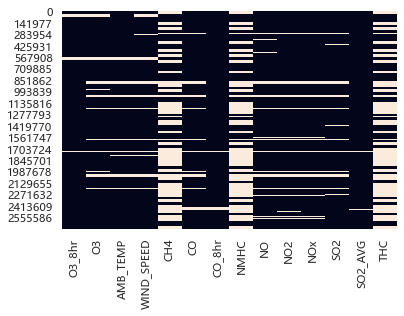

In [11]:
# 變數缺值情形
sns.heatmap(df[pic_cols].isnull(), cbar=False)

<AxesSubplot:>

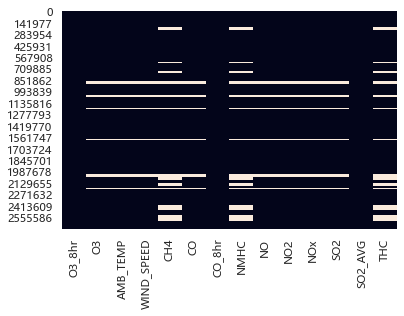

In [12]:
# 缺值以空品區平均補值
for c in pic_cols:
    mask = df[c].isnull()
    df.loc[mask, c] = df.loc[:, gp_col].merge(df_gp_area_mean[gp_col+[c]], how="left", on=gp_col).loc[mask, c]

# 變數缺值情形
sns.heatmap(df[pic_cols].isnull(), cbar=False)

## 挑選

In [13]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic = df[pic_mask].reset_index(drop=True)
df_pic.info() # CO2 在這幾個測站沒有測

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244152 entries, 0 to 244151
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          244152 non-null  object        
 1   DataCreationDate  244152 non-null  datetime64[ns]
 2   O3_8hr            244149 non-null  float64       
 3   CO_8hr            244149 non-null  float64       
 4   PM2.5_AVG         240797 non-null  float64       
 5   PM10_AVG          239490 non-null  float64       
 6   SO2_AVG           243945 non-null  float64       
 7   AMB_TEMP          243720 non-null  float64       
 8   CH4               243720 non-null  float64       
 9   CO                243720 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243720 non-null  float64       
 12  NO                243720 non-null  float64       
 13  NO2               243720 non-null  float64       
 14  NOx 

In [14]:
# 移除遺漏值
df_pic.dropna(subset=["O3_8hr", "O3"], inplace=True)

In [15]:
# 合併 冷熱季 欄位
# 改以考量 溫度

## 變數

In [16]:
#定義實際超標門檻值
exceed_value_real = 71 #實際超標門檻值(臭氧橘警71)
df_pic.loc[:,"O3_8hr_max"] = df_pic.loc[:,["SiteName","date","O3_8hr"]].groupby(by=["SiteName","date"]).transform(max).values
df_pic.loc[:,"is_exceed_date"] = df_pic.loc[:,"O3_8hr_max"] >= exceed_value_real

# 抓出超標時間點，合併回df_pic
df_pic_real_exceed_time = df_pic[df_pic["O3_8hr"]>=exceed_value_real][["SiteName","date","DataCreationDate"]].groupby(
                                                            ["SiteName","date"], as_index=False).min()
df_pic_real_exceed_time.loc[:,"real_exceed_hour"] = df_pic_real_exceed_time.loc[:,"DataCreationDate"].dt.hour
df_pic = df_pic.merge(df_pic_real_exceed_time[["SiteName","date","real_exceed_hour"]], how="left", on=["SiteName","date"])

### 變數單位

In [17]:
# 讀入單位表
Unit_table_path = r"G:\我的雲端硬碟\python\output\0715\air_monitor_UnitTable_20210715_13.41.55.csv"
Unit_table = read_data_dir_fPathExt(Unit_table_path)
Unit_table

  >> 讀取:: G:\我的雲端硬碟\python\output\0715\air_monitor_UnitTable_20210715_13.41.55.csv


,_idx,ItemEngName,ItemUnit
0,0,SO2,ppb
1,1,CO,ppm
2,2,O3,ppb
3,3,PM10,μg/m3
4,4,NOx,ppb
5,5,NO,ppb
6,6,NO2,ppb
7,7,THC,ppm
8,8,NMHC,ppm
9,9,WIND_SPEED,m/sec


### 計算最大值

In [18]:
# 計算每日O3_8hr、O3最大值
cols = ["O3_8hr","O3","AMB_TEMP"]
gp_cols = ["SiteName","date"]
df_daily_max = df_pic[gp_cols+cols].groupby(by=gp_cols, as_index=False).max()
for c in cols:
    df_daily_max.rename(columns={c:f"{c}_max"}, inplace=True)
    
df_daily_max.columns

Index(['SiteName', 'date', 'O3_8hr_max', 'O3_max', 'AMB_TEMP_max'], dtype='object')

In [19]:
df_daily_max["date"].nunique()

1092

In [20]:
# # 檢查 (跳過 移除遺漏值 步驟)
# mask = (df_daily_max["SiteName"].isin(["南投"])) & (df_daily_max["date"].apply(lambda d: d.year == 2019)) & ((pd.isna(df_daily_max["O3_max"])))
# formtoXlsx(df_daily_max[mask].reset_index(drop=True), "2019年_南投測站_O3全天都缺值日期")

In [21]:
# 相關性
df_daily_max.corr(method ='pearson')

,O3_8hr_max,O3_max,AMB_TEMP_max
O3_8hr_max,1.000000,0.939844,0.144343
O3_max,0.939844,1.000000,0.233059
AMB_TEMP_max,0.144343,0.233059,1.000000


In [22]:
# df_result
df_result = df_daily_max.copy(deep=True)

### 監測因子相關

#### 每日小時值 最大值

In [458]:
objectMax_lst = ["CO", "NOx","NO","NO2","SO2", "AMB_TEMP", "CH4", "NMHC", "THC"]

In [459]:
# df_result 重置
df_result = df_daily_max.drop(columns=["AMB_TEMP_max"]).copy(deep=True)

# 計算每日小時值 最大值
gp_cols = ["SiteName","date"]
df_daily_max_others = df_pic[gp_cols+objectMax_lst].groupby(by=gp_cols, as_index=False).max()
for col in objectMax_lst:
    df_daily_max_others.rename(columns={col:f"{col}_max"}, inplace=True)
    df_result = df_result.merge(df_daily_max_others[["SiteName","date",f"{col}_max"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_max,NOx_max,NO_max,NO2_max,SO2_max,AMB_TEMP_max,CH4_max,NMHC_max,THC_max
0,南投,2018-01-01,45.0,58.000000,0.66,35.0,10.00,32.0,3.0,25.7,1.9,0.15,2.0
1,南投,2018-01-02,41.0,54.000000,1.36,54.0,38.00,41.0,8.6,26.9,2.1,0.47,2.4
2,南投,2018-01-03,53.0,79.000000,1.15,45.0,5.48,42.0,7.8,26.1,2.0,0.83,2.8
3,南投,2018-01-04,30.0,45.000000,0.99,55.0,25.00,42.0,4.1,22.9,2.0,0.39,2.3
4,南投,2018-01-05,7.0,20.333333,0.96,54.0,28.00,33.0,4.9,22.1,1.9,0.41,2.2


In [460]:
# 整合成 df_pic1
df_pic_1 = df_pic.merge(df_result.drop(columns=["O3_8hr_max"]), how="left", on=["SiteName","date"])
df_pic_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max      1.000000
O3_max          0.939844
CO_max          0.020027
NOx_max        -0.099018
NO_max         -0.203906
NO2_max         0.045028
SO2_max         0.058113
AMB_TEMP_max    0.144343
CH4_max         0.250621
NMHC_max       -0.011952
THC_max         0.176341
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

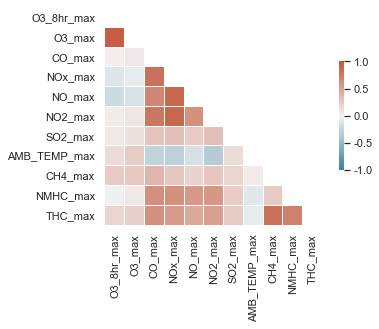

In [461]:
# 相關性 每日MAX 相關性太低 除了O3 MAX
object_lst_new = [f"{obj}_max" for obj in objectMax_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max", "O3_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max", "O3_max"]])

corr = df_result[["O3_8hr_max","O3_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

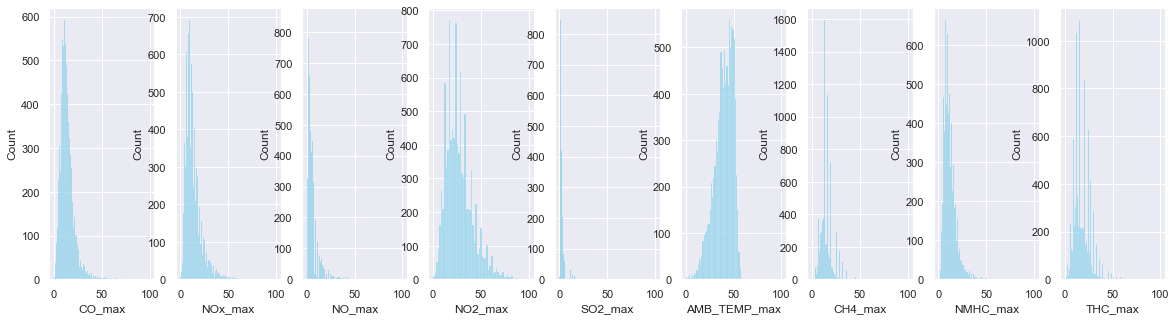

In [462]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(20, 5))

for idx, col in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=col, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [465]:
# print(df_result.plot.scatter(x="CO_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="NOx_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="NMHC_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="O3_max", y="O3_8hr_max", color="b"))

In [464]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max", "O3_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max", "O3_max"]])

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


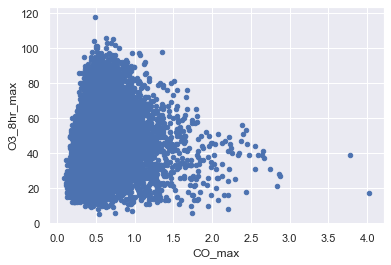

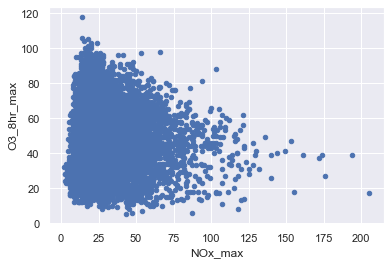

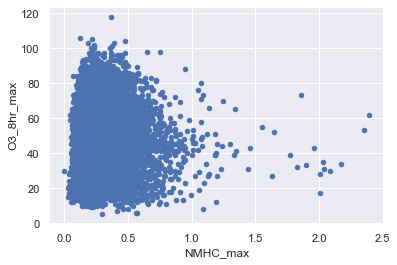

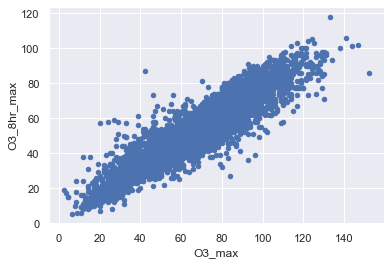

In [449]:
# print(df_result.plot.scatter(x="CO_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="NOx_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="NMHC_max", y="O3_8hr_max", color="b"))
# print(df_result.plot.scatter(x="O3_max", y="O3_8hr_max", color="b"))

#### 每日0點 小時值

In [31]:
object_lst = ["CO", "NOx","NO","NO2","SO2"]

In [32]:
time = 0

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0點 CO小時值
mask = (df_pic["DataCreationDate"].dt.hour==time)

# 合併 df_result
for obj in object_lst:
    df_result = df_result.merge(df_pic.loc[mask, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_result.rename(columns={obj:f"{obj}_at{time}"}, inplace=True)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,CO_at0,NOx_at0,NO_at0,NO2_at0,SO2_at0
0,南投,2018-01-01,45.0,58.000000,0.55,18.0,0.7,17.0,2.5
1,南投,2018-01-02,41.0,54.000000,0.56,26.0,2.8,24.0,2.2
2,南投,2018-01-03,53.0,79.000000,0.46,17.0,2.0,15.0,1.2
3,南投,2018-01-04,30.0,45.000000,0.79,28.0,2.1,26.0,2.4
4,南投,2018-01-05,7.0,20.333333,0.40,21.0,1.7,20.0,4.9


In [33]:
# 整合成 df_pic2
df_pic_2 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_2.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'CO_at0', 'NOx_at0', 'NO_at0', 'NO2_at0',
       'SO2_at0'],
      dtype='object')

O3_8hr_max    1.000000
CO_at0        0.163545
NOx_at0       0.013403
NO_at0       -0.125045
NO2_at0       0.085592
SO2_at0      -0.031215
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

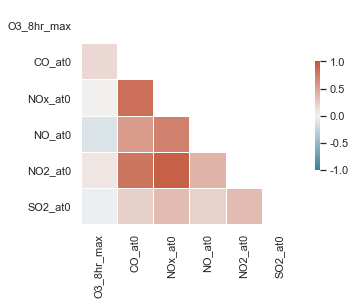

In [34]:
# 相關性 每日0點  相關性太低
object_lst_new = [f"{obj}_at{time}" for obj in object_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

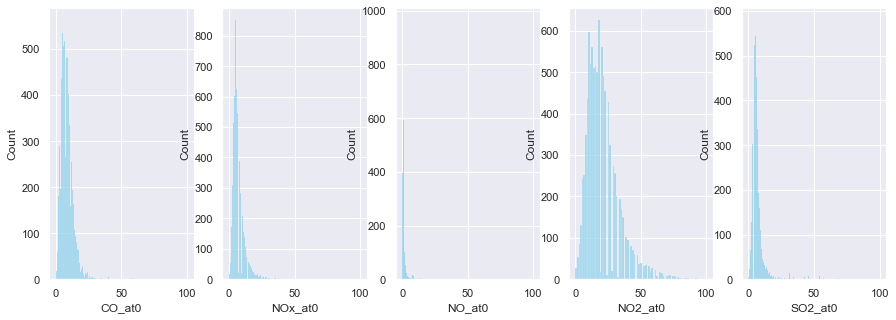

In [35]:
# 畫出直方圖 (# normalized)

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst), figsize=(15, 5))

for idx, col in enumerate(object_lst):
    sns.histplot(data=df_result, x=f"{col}_at{time}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [ ]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日0、7點 提升量(gradian)

In [36]:
objectGradian_lst = ["O3","CO", "NOx","NO","NO2","SO2"]

In [37]:
time_start = 0
time_end = 7

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0、7點 小時值
mask_start = (df_pic["DataCreationDate"].dt.hour==time_start)
mask_end = (df_pic["DataCreationDate"].dt.hour==time_end)

# 計算差值、百分比 gradian
for obj in objectGradian_lst:
    df_gradian = df_pic.loc[mask_start, ["SiteName","date", obj]].merge(
                        df_pic.loc[mask_end, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_gradian.rename(columns={f"{obj}_x":f"{obj}_at{time_start}", f"{obj}_y":f"{obj}_at{time_end}"}, inplace=True)
    
#     計算
    df_gradian.loc[:,f"{obj}_gradian_diff_{time_start}to{time_end}"] = df_gradian.loc[:,f"{obj}_at{time_end}"] - df_gradian.loc[:,f"{obj}_at{time_start}"]
#     df_gradian.loc[:,f"{obj}_gradian_ratio"] = (df_gradian.loc[:,f"{obj}_gradian_diff"] / df_gradian.loc[:,f"{obj}_at{time_end}"])*100
#     去除重複 (因取兩個時間點，在串資料時會*2)
    df_gradian.drop_duplicates(keep="first", inplace=True)
    df_result = df_result.merge(df_gradian[["SiteName","date",f"{obj}_gradian_diff_{time_start}to{time_end}"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,O3_gradian_diff_0to7,CO_gradian_diff_0to7,NOx_gradian_diff_0to7,NO_gradian_diff_0to7,NO2_gradian_diff_0to7,SO2_gradian_diff_0to7
0,南投,2018-01-01,45.0,58.000000,-10.9,-0.03,15.0,7.0,8.0,-0.6
1,南投,2018-01-02,41.0,54.000000,0.1,0.32,25.0,35.2,-11.0,0.3
2,南投,2018-01-03,53.0,79.000000,-0.5,0.15,6.0,2.5,3.0,-0.1
3,南投,2018-01-04,30.0,45.000000,-4.9,0.13,14.0,18.9,-5.0,-1.8
4,南投,2018-01-05,7.0,20.333333,-4.7,0.22,18.0,18.3,0.0,-3.1


In [38]:
# 整合成 df_pic3
df_pic_3 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SiteName               243717 non-null  object        
 1   DataCreationDate       243717 non-null  datetime64[ns]
 2   O3_8hr                 243717 non-null  float64       
 3   CO_8hr                 243717 non-null  float64       
 4   PM2.5_AVG              240365 non-null  float64       
 5   PM10_AVG               239058 non-null  float64       
 6   SO2_AVG                243513 non-null  float64       
 7   AMB_TEMP               241822 non-null  float64       
 8   CH4                    243717 non-null  float64       
 9   CO                     243717 non-null  float64       
 10  CO2                    0 non-null       float64       
 11  NMHC                   243717 non-null  float64       
 12  NO                     243717 non-null  floa

O3_8hr_max               1.000000
O3_gradian_diff_0to7    -0.175231
CO_gradian_diff_0to7    -0.041639
NOx_gradian_diff_0to7   -0.037468
NO_gradian_diff_0to7    -0.019225
NO2_gradian_diff_0to7   -0.040966
SO2_gradian_diff_0to7   -0.002098
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

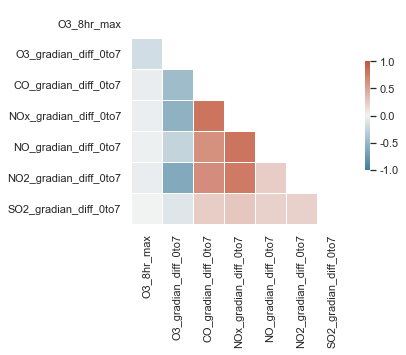

In [39]:
# 相關性 每日gradian 相關性太低 
object_lst_new = [f"{obj}_gradian_diff_{time_start}to{time_end}" for obj in objectGradian_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

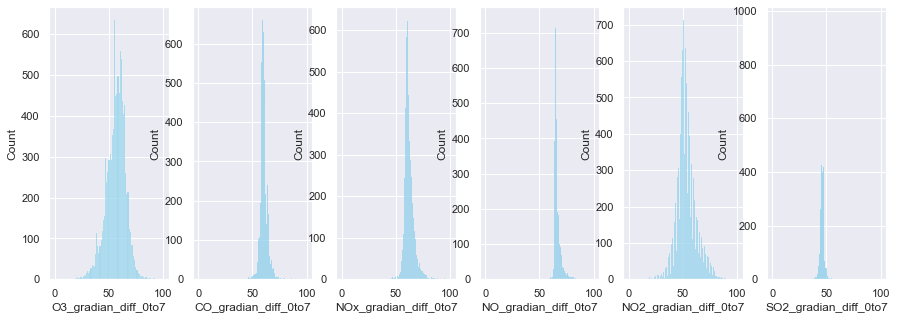

In [40]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_gradian_diff_{time_start}to{time_end}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [ ]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日7、12點 提升量(gradian)

In [41]:
objectGradian_lst = ["O3","CO", "NOx","NO","NO2","SO2"]

In [42]:
time_start = 7
time_end = 12

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0、7點 小時值
mask_start = (df_pic["DataCreationDate"].dt.hour==time_start)
mask_end = (df_pic["DataCreationDate"].dt.hour==time_end)

# 計算差值、百分比 gradian
for obj in objectGradian_lst:
    df_gradian = df_pic.loc[mask_start, ["SiteName","date", obj]].merge(
                        df_pic.loc[mask_end, ["SiteName","date", obj]], how="left", on=["SiteName","date"])
    df_gradian.rename(columns={f"{obj}_x":f"{obj}_at{time_start}", f"{obj}_y":f"{obj}_at{time_end}"}, inplace=True)
    
#     計算
    df_gradian.loc[:,f"{obj}_gradian_diff_{time_start}to{time_end}"] = df_gradian.loc[:,f"{obj}_at{time_end}"] - df_gradian.loc[:,f"{obj}_at{time_start}"]
#     df_gradian.loc[:,f"{obj}_gradian_ratio"] = (df_gradian.loc[:,f"{obj}_gradian_diff"] / df_gradian.loc[:,f"{obj}_at{time_end}"])*100
#     去除重複 (因取兩個時間點，在串資料時會*2)
    df_gradian.drop_duplicates(keep="first", inplace=True)
    df_result = df_result.merge(df_gradian[["SiteName","date",f"{obj}_gradian_diff_{time_start}to{time_end}"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,O3_gradian_diff_7to12,CO_gradian_diff_7to12,NOx_gradian_diff_7to12,NO_gradian_diff_7to12,NO2_gradian_diff_7to12,SO2_gradian_diff_7to12
0,南投,2018-01-01,45.0,58.000000,38.9,-0.06,-16.0,-5.2,-10.0,0.4
1,南投,2018-01-02,41.0,54.000000,47.0,-0.37,-27.0,-33.2,6.0,2.0
2,南投,2018-01-03,53.0,79.000000,57.9,-0.15,-10.0,-3.6,-6.0,2.3
3,南投,2018-01-04,30.0,45.000000,42.3,-0.48,-22.0,-17.8,-4.0,1.2
4,南投,2018-01-05,7.0,20.333333,7.3,0.07,15.0,1.0,13.0,2.0


In [43]:
# 整合成 df_pic4
df_pic_4 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   SiteName                243717 non-null  object        
 1   DataCreationDate        243717 non-null  datetime64[ns]
 2   O3_8hr                  243717 non-null  float64       
 3   CO_8hr                  243717 non-null  float64       
 4   PM2.5_AVG               240365 non-null  float64       
 5   PM10_AVG                239058 non-null  float64       
 6   SO2_AVG                 243513 non-null  float64       
 7   AMB_TEMP                241822 non-null  float64       
 8   CH4                     243717 non-null  float64       
 9   CO                      243717 non-null  float64       
 10  CO2                     0 non-null       float64       
 11  NMHC                    243717 non-null  float64       
 12  NO                      243717

O3_8hr_max                1.000000
O3_gradian_diff_7to12     0.733884
CO_gradian_diff_7to12     0.009885
NOx_gradian_diff_7to12   -0.112226
NO_gradian_diff_7to12    -0.060718
NO2_gradian_diff_7to12   -0.126643
SO2_gradian_diff_7to12    0.144447
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

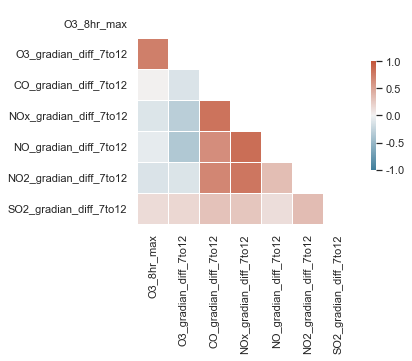

In [44]:
# 相關性 每日gradian 相關性太低 
object_lst_new = [f"{obj}_gradian_diff_{time_start}to{time_end}" for obj in objectGradian_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

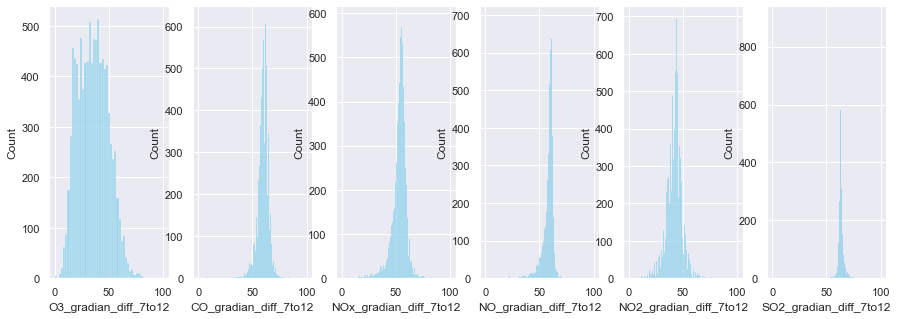

In [45]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(objectGradian_lst), figsize=(15, 5))

for idx, col in enumerate(objectGradian_lst):
    sns.histplot(data=df_result, x=f"{col}_gradian_diff_{time_start}to{time_end}", kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [ ]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日0~7點 平均值

In [450]:
objectMean_lst = ["O3","CO","NO2","NMHC"] #前驅物

In [451]:
time_start = 0
time_end = 7

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_0to7mean,CO_0to7mean,NO2_0to7mean,NMHC_0to7mean
9823,竹山,2020-12-27,31.0,39.2,24.3,8.5375,0.27875,8.4750,0.116250
9824,竹山,2020-12-28,42.0,64.9,27.4,5.8625,0.19750,5.5500,0.089107
9825,竹山,2020-12-29,45.0,72.9,26.4,5.4750,0.48125,15.4375,0.178571
9826,竹山,2020-12-30,31.0,39.7,19.3,8.4000,0.36750,11.6375,0.106071
9827,竹山,2020-12-31,26.0,28.5,11.3,25.8250,0.27500,7.3125,0.059107


In [452]:
# 整合成 df_pic5
df_pic_5 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max       1.000000
O3_0to7mean      0.179793
CO_0to7mean      0.233518
NO2_0to7mean     0.123052
NMHC_0to7mean    0.192020
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

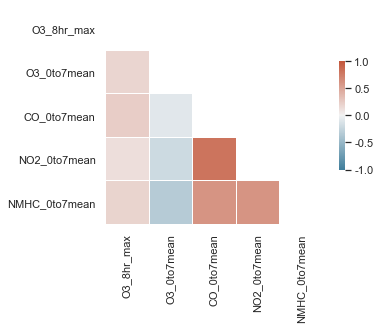

In [453]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

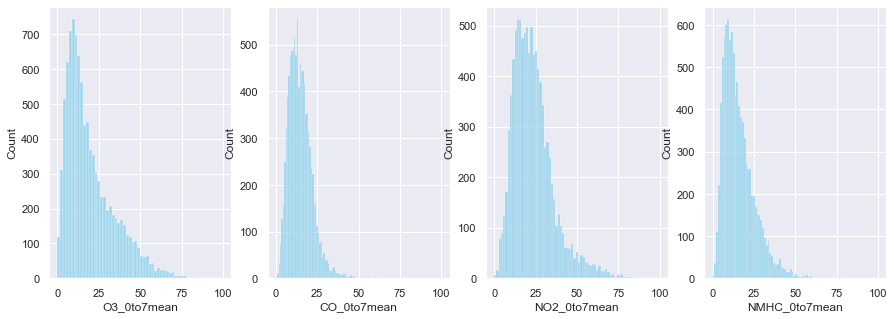

In [454]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [37]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日1~6點 平均值

In [476]:
objectMean_lst = ["O3","CO","NO2","NMHC"] #前驅物

In [477]:
time_start = 1
time_end = 6

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_1to6mean,CO_1to6mean,NO2_1to6mean,NMHC_1to6mean
9823,竹山,2020-12-27,31.0,39.2,24.3,8.950000,0.260000,7.783333,0.109762
9824,竹山,2020-12-28,42.0,64.9,27.4,5.000000,0.180000,5.316667,0.080238
9825,竹山,2020-12-29,45.0,72.9,26.4,4.733333,0.466667,15.283333,0.179048
9826,竹山,2020-12-30,31.0,39.7,19.3,7.433333,0.376667,12.283333,0.088810
9827,竹山,2020-12-31,26.0,28.5,11.3,26.250000,0.271667,7.150000,0.056905


In [478]:
# 整合成 df_pic6
df_pic_6 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max       1.000000
O3_1to6mean      0.150588
CO_1to6mean      0.258377
NO2_1to6mean     0.137040
NMHC_1to6mean    0.194676
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

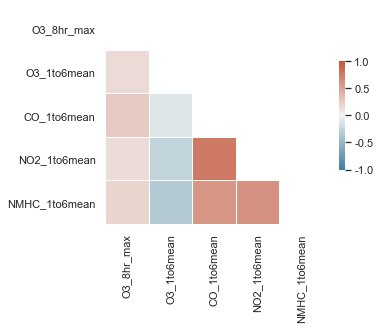

In [479]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

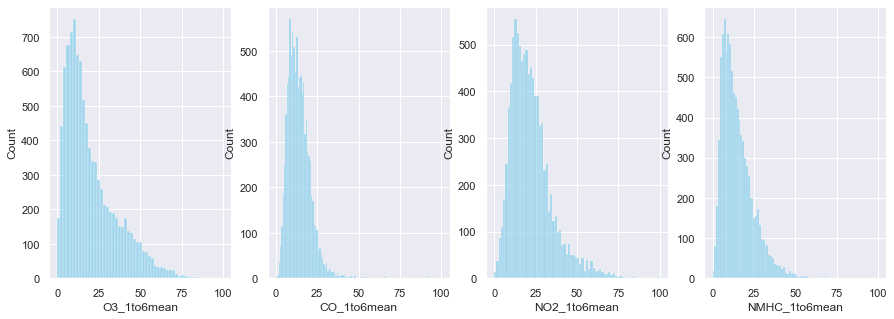

In [480]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [481]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日0~5點 平均值 (含風速、溫度)

In [560]:
objectMean_lst = ["O3","WIND_SPEED","AMB_TEMP","CO","NMHC"] #前驅物堆積

In [561]:
time_start = 0
time_end = 5

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_0to5mean,WIND_SPEED_0to5mean,AMB_TEMP_0to5mean,CO_0to5mean,NMHC_0to5mean
9823,竹山,2020-12-27,31.0,39.2,24.3,9.250000,1.050000,16.350000,0.258333,0.108571
9824,竹山,2020-12-28,42.0,64.9,27.4,6.950000,0.900000,17.816667,0.163333,0.083810
9825,竹山,2020-12-29,45.0,72.9,26.4,6.533333,0.633333,19.033333,0.451667,0.192381
9826,竹山,2020-12-30,31.0,39.7,19.3,5.383333,1.183333,18.216667,0.373333,0.114524
9827,竹山,2020-12-31,26.0,28.5,11.3,26.550000,1.416667,10.650000,0.276667,0.054524


In [562]:
# 整合成 df_pic7
df_pic_7 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   SiteName             243717 non-null  object        
 1   DataCreationDate     243717 non-null  datetime64[ns]
 2   O3_8hr               243717 non-null  float64       
 3   CO_8hr               243717 non-null  float64       
 4   PM2.5_AVG            240365 non-null  float64       
 5   PM10_AVG             239058 non-null  float64       
 6   SO2_AVG              243513 non-null  float64       
 7   AMB_TEMP             243717 non-null  float64       
 8   CH4                  243717 non-null  float64       
 9   CO                   243717 non-null  float64       
 10  CO2                  0 non-null       float64       
 11  NMHC                 243717 non-null  float64       
 12  NO                   243717 non-null  float64       
 13  NO2           

O3_8hr_max             1.000000
O3_0to5mean            0.182813
WIND_SPEED_0to5mean   -0.202881
AMB_TEMP_0to5mean     -0.110218
CO_0to5mean            0.242315
NMHC_0to5mean          0.183475
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

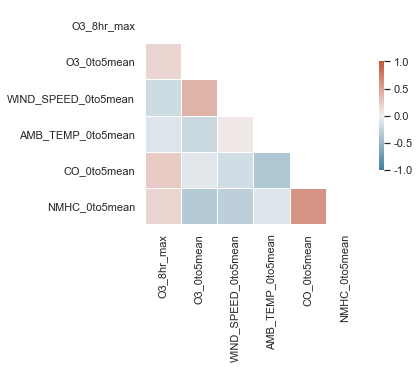

In [563]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

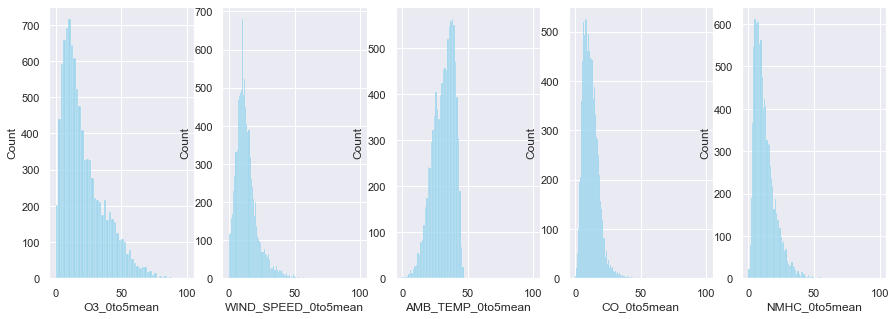

In [564]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [565]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日0~5點 平均值 (含風速)、溫度最大值

In [27]:
objectMean_lst = ["O3","WIND_SPEED","CO","NMHC"] #前驅物堆積

In [28]:
time_start = 0
time_end = 5

# df_result 重置
df_result = df_daily_max.copy(deep=True)

# 取每日0~7點 小時值
mask_range = (df_pic["DataCreationDate"].dt.hour>=time_start) & (df_pic["DataCreationDate"].dt.hour<=time_end)

# 計算 平均值
gp_cols = ["SiteName","date"]
df_mean = df_pic.loc[mask_range, gp_cols+objectMean_lst].groupby(gp_cols, as_index=False).mean()

for obj in objectMean_lst:
    df_mean.rename(columns={f"{obj}":f"{obj}_{time_start}to{time_end}mean"}, inplace=True)
    
# 串回 df_result
df_mean.drop_duplicates(keep="first", inplace=True)
df_result = df_result.merge(df_mean, how="left", on=gp_cols)

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.tail()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max,O3_0to5mean,WIND_SPEED_0to5mean,CO_0to5mean,NMHC_0to5mean
9823,竹山,2020-12-27,31.0,39.2,24.3,9.250000,1.050000,0.258333,0.108571
9824,竹山,2020-12-28,42.0,64.9,27.4,6.950000,0.900000,0.163333,0.083810
9825,竹山,2020-12-29,45.0,72.9,26.4,6.533333,0.633333,0.451667,0.192381
9826,竹山,2020-12-30,31.0,39.7,19.3,5.383333,1.183333,0.373333,0.114524
9827,竹山,2020-12-31,26.0,28.5,11.3,26.550000,1.416667,0.276667,0.054524


In [29]:
# 整合成 df_pic8
df_pic_8 = df_pic.merge(df_result.drop(columns=["O3_8hr_max","O3_max"]), how="left", on=["SiteName","date"])
df_pic_8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   SiteName             243717 non-null  object        
 1   DataCreationDate     243717 non-null  datetime64[ns]
 2   O3_8hr               243717 non-null  float64       
 3   CO_8hr               243717 non-null  float64       
 4   PM2.5_AVG            240365 non-null  float64       
 5   PM10_AVG             239058 non-null  float64       
 6   SO2_AVG              243513 non-null  float64       
 7   AMB_TEMP             243717 non-null  float64       
 8   CH4                  243717 non-null  float64       
 9   CO                   243717 non-null  float64       
 10  CO2                  0 non-null       float64       
 11  NMHC                 243717 non-null  float64       
 12  NO                   243717 non-null  float64       
 13  NO2           

O3_8hr_max             1.000000
O3_0to5mean            0.182813
WIND_SPEED_0to5mean   -0.202881
CO_0to5mean            0.242315
NMHC_0to5mean          0.183475
AMB_TEMP_max           0.144343
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

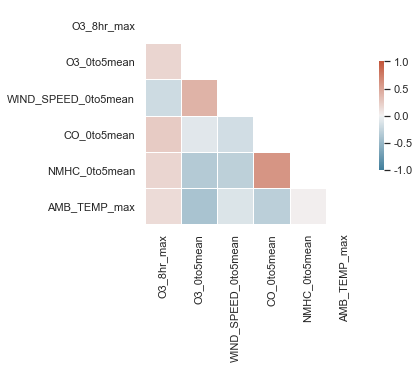

In [30]:
# 相關性
object_lst_new = [f"{obj}_{time_start}to{time_end}mean" for obj in objectMean_lst] + ["AMB_TEMP_max"]

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max"]])

corr = df_result[["O3_8hr_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

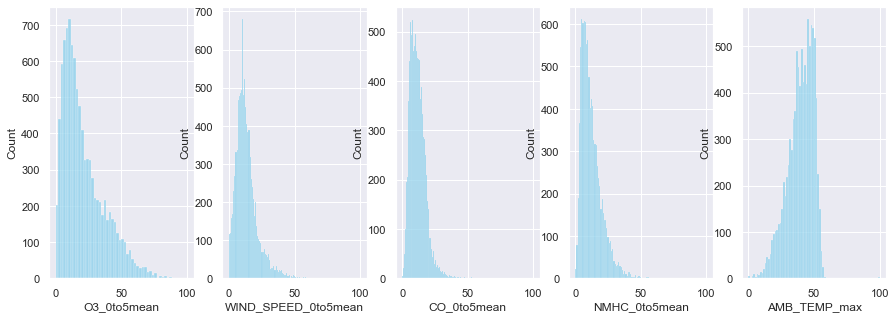

In [31]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, len(object_lst_new), figsize=(15, 5))

for idx, obj in enumerate(object_lst_new):
    sns.histplot(data=df_result, x=obj, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [32]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max"]])

#### 每日 O3最大值、溫度最大值

In [39]:
objectMax_lst = ["AMB_TEMP"]

In [40]:
# df_result 重置
df_result = df_daily_max.drop(columns=["AMB_TEMP_max"]).copy(deep=True)

# 計算每日小時值 最大值
gp_cols = ["SiteName","date"]
df_daily_max_others = df_pic[gp_cols+objectMax_lst].groupby(by=gp_cols, as_index=False).max()
for col in objectMax_lst:
    df_daily_max_others.rename(columns={col:f"{col}_max"}, inplace=True)
    df_result = df_result.merge(df_daily_max_others[["SiteName","date",f"{col}_max"]], how="left", on=["SiteName","date"])

df_result.drop_duplicates(keep="first", inplace=True) # 去重複    
df_result.head()

,SiteName,date,O3_8hr_max,O3_max,AMB_TEMP_max
0,南投,2018-01-01,45.0,58.000000,25.7
1,南投,2018-01-02,41.0,54.000000,26.9
2,南投,2018-01-03,53.0,79.000000,26.1
3,南投,2018-01-04,30.0,45.000000,22.9
4,南投,2018-01-05,7.0,20.333333,22.1


In [41]:
# 整合成 df_pic9
df_pic_9 = df_pic.merge(df_result.drop(columns=["O3_8hr_max"]), how="left", on=["SiteName","date"])
df_pic_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243717 entries, 0 to 243716
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   SiteName          243717 non-null  object        
 1   DataCreationDate  243717 non-null  datetime64[ns]
 2   O3_8hr            243717 non-null  float64       
 3   CO_8hr            243717 non-null  float64       
 4   PM2.5_AVG         240365 non-null  float64       
 5   PM10_AVG          239058 non-null  float64       
 6   SO2_AVG           243513 non-null  float64       
 7   AMB_TEMP          243717 non-null  float64       
 8   CH4               243717 non-null  float64       
 9   CO                243717 non-null  float64       
 10  CO2               0 non-null       float64       
 11  NMHC              243717 non-null  float64       
 12  NO                243717 non-null  float64       
 13  NO2               243717 non-null  float64       
 14  NOx 

O3_8hr_max      1.000000
O3_max          0.939844
AMB_TEMP_max    0.144343
Name: O3_8hr_max, dtype: float64


<AxesSubplot:>

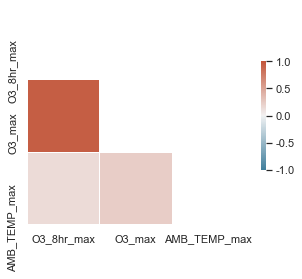

In [49]:
# 相關性 每日MAX 相關性太低 除了O3 MAX
object_lst_new = [f"{obj}_max" for obj in objectMax_lst] 

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_result[object_lst_new + ["O3_8hr_max", "O3_max"]] = min_max_scaler.fit_transform(df_result[object_lst_new + ["O3_8hr_max", "O3_max"]])

corr = df_result[["O3_8hr_max","O3_max"]+object_lst_new].corr(method ='pearson')
print(corr["O3_8hr_max"])

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

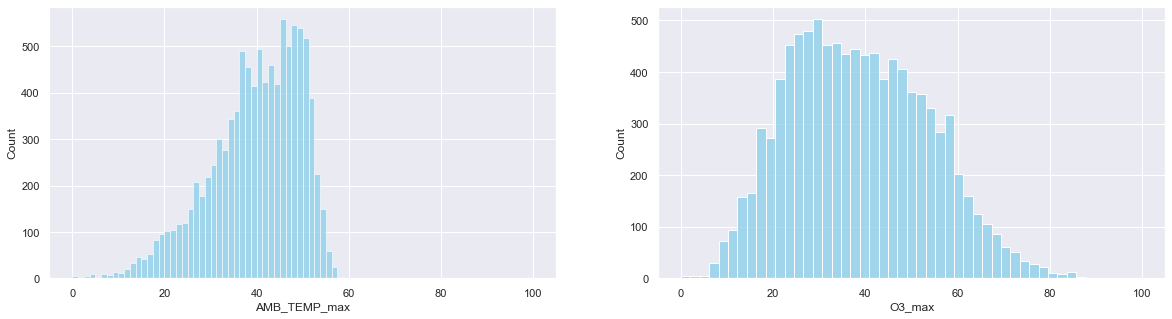

In [50]:
# 畫出直方圖
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
object_lst_new_tmp = object_lst_new + ["O3_max"]
fig, axs = plt.subplots(1, len(object_lst_new_tmp), figsize=(20, 5))

for idx, col in enumerate(object_lst_new_tmp):
    sns.histplot(data=df_result, x=col, kde=False, color="skyblue", ax=axs[idx])

plt.show()

In [51]:
# normalized back
df_result.loc[:,object_lst_new + ["O3_8hr_max", "O3_max"]] = min_max_scaler.inverse_transform(df_result.loc[:,object_lst_new + ["O3_8hr_max", "O3_max"]])

### 上風處測站相關

- 中: 沙鹿、線西、 彰化、員林 > 南投

In [334]:
# 篩選測站 & 篩選年分
site_lst = ["南投", "沙鹿","西屯","忠明","豐原", "線西", "彰化","彰化(員林)","二林"]
year_min_max = [2018,2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year>=year_min_max[0]) & (df["DataCreationDate"].dt.year<=year_min_max[1])
df_pic_for_fornt = df[pic_mask].reset_index(drop=True)
df_pic_for_fornt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219951 entries, 0 to 219950
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             219951 non-null  int64         
 1   SiteName          219951 non-null  object        
 2   County            219951 non-null  object        
 3   AQI               217214 non-null  float64       
 4   Pollutant         112354 non-null  object        
 5   Status            219810 non-null  object        
 6   SO2               213826 non-null  float64       
 7   CO                216155 non-null  float64       
 8   O3                215615 non-null  float64       
 9   O3_8hr            218108 non-null  float64       
 10  PM10              213080 non-null  float64       
 11  PM2.5             211361 non-null  float64       
 12  NO2               213578 non-null  float64       
 13  NOx               213629 non-null  float64       
 14  NO  

In [335]:
target_site = site_lst[0]
front_site_lst = site_lst[1:]
y = "O3_8hr"
x = "CO"

In [336]:
mask_y = df_pic_for_fornt["SiteName"].isin([target_site])
datay = df_pic_for_fornt.loc[mask_y, y].reset_index(drop=True)
# datay.head()

In [337]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(-lag)) # x往前推

In [338]:
front = 7
range_setting = range(front,1,-1)

In [339]:
plot_dict = {}
for f in front_site_lst:
    mask_x = df_pic_for_fornt["SiteName"].isin([f])
    print(f)
    datax = df_pic_for_fornt.loc[mask_x, x].reset_index(drop=True)
    a = [crosscorr(datax, datay, lag=i) for i in range_setting]
    print(a)
    plot_dict[f] = a

沙鹿
[0.1315100968227386, 0.1428766605341226, 0.14433712114125324, 0.13415575086437545, 0.11299303311438694, 0.0817132153282169]
西屯
[0.16042132286345004, 0.16074096610212293, 0.14979293493121218, 0.12603179785114757, 0.08932480642327324, 0.04293201600563982]
忠明
[0.12156501746345895, 0.1460296076286969, 0.1576576783968007, 0.15174411280699523, 0.12795444538827613, 0.08757761764367696]
豐原
[-0.07797921183460814, -0.07344089854039118, -0.06478813011090942, -0.054127606524815575, -0.04267527784397295, -0.031396893400989764]
線西
[0.023151813214743393, 0.01825926525897301, 0.014728135271598311, 0.012598844659000553, 0.013459052671969146, 0.016494284222780375]
彰化
[0.07199874434455218, 0.10006719043468716, 0.11646660304122168, 0.11838724647245931, 0.10533843802385448, 0.08088952829818014]
彰化(員林)
[0.05653457584346071, 0.044166837281126164, 0.03053257848743845, 0.017137500034272325, 0.005355137670348597, -0.00423394176443327]
二林
[0.13371545147652236, 0.12504847037433953, 0.10971236380383237, 0.08802

Text(0.5, 1.0, '南投站O3小時值 與周遭測站 CO前幾小時值 時間相關性')

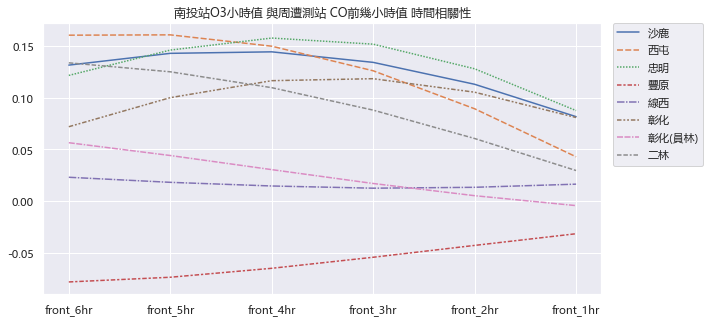

In [342]:
plt.figure(figsize=(10,5))
g = sns.lineplot(data=plot_dict)
g.set_xticks(range(front-1)) # <--- set the ticks first
g.set_xticklabels([f"front_{i-1}hr" for i in range_setting])
g.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g.set_title(f"{target_site}站O3小時值 與周遭測站 CO前幾小時值 時間相關性")


> - 觀察曲線斜率，若有明顯**隨時間下降**趨勢，代表有成為 **先行指標**的效果
> - 除了 豐原以外，多數測站(西屯、沙鹿、忠明、二林) 可作為 南投測站 的有效上風測站(先行指標)

小時值畫圖觀察

In [529]:
# 篩選測站 & 篩選年分
site_lst = ["南投"]
year_min_max = [2020]
pic_mask = (df_pic["SiteName"].isin(site_lst)) & (df_pic["DataCreationDate"].dt.year==year_min_max[0])
df_pic_for_min = df_pic[pic_mask].reset_index(drop=True)
df_pic_for_min.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour'],
      dtype='object')

In [530]:
max_date = df_pic_for_min[df_pic_for_min["O3_8hr"]>=71]["date"].unique().max()
max_date

datetime.date(2020, 11, 26)

In [531]:
# object_pic = ["CO","NOx","NMHC","AMB_TEMP","WIND_SPEED","O3","O3_8hr"]
object_pic = ["CO","AMB_TEMP","WIND_SPEED","O3","O3_8hr"]
linewidths = [1]*(len(object_pic)-2) + [3]*2

# normalized
feature_range = (0, 100)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
df_pic_for_min[object_pic] = min_max_scaler.fit_transform(df_pic_for_min[object_pic])

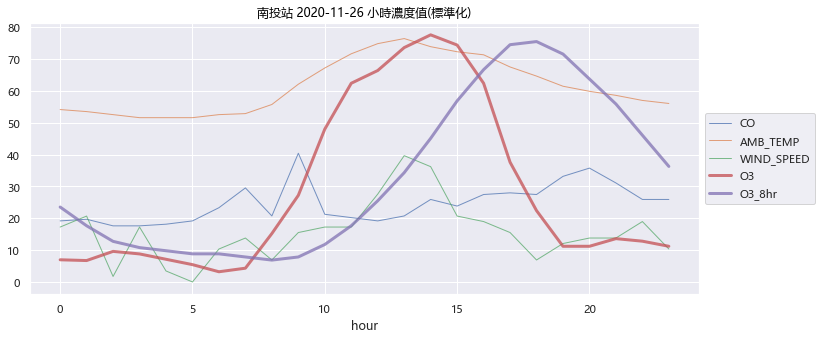

In [532]:
date_lst = [max_date] #  only one date
mask =  (df_pic_for_min["date"].isin(date_lst))
df_pic_for_min.loc[:,"hour"] = df_pic_for_min.loc[:,"DataCreationDate"].dt.hour
df_hour_for_plot = df_pic_for_min[mask].sort_values(by=["hour"])[["hour"]+object_pic].set_index('hour')

# 畫圖
f = plt.figure(figsize=(12,5))
plt.title(f'{site_lst[0]}站 {max_date} 小時濃度值(標準化)', color='black')
for c,lw in zip(object_pic,linewidths):
    df_hour_for_plot[c].plot(alpha=0.75, ax=f.gca(), lw=lw)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

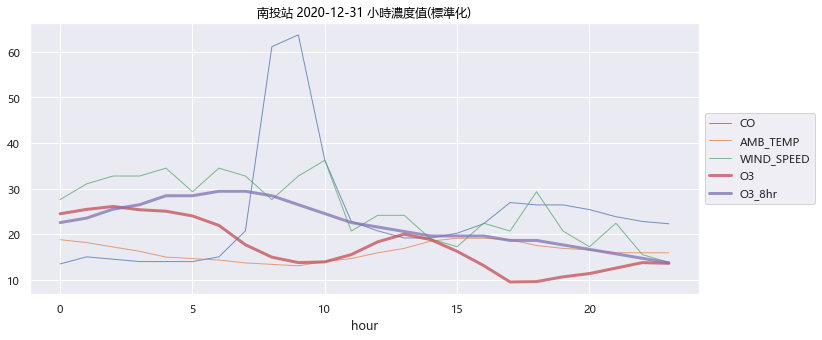

In [528]:
date_lst = [max_date] #  only one date
mask =  (df_pic_for_min["date"].isin(date_lst))
df_pic_for_min.loc[:,"hour"] = df_pic_for_min.loc[:,"DataCreationDate"].dt.hour
df_hour_for_plot = df_pic_for_min[mask].sort_values(by=["hour"])[["hour"]+object_pic].set_index('hour')

# 畫圖
f = plt.figure(figsize=(12,5))
plt.title(f'{site_lst[0]}站 {max_date} 小時濃度值(標準化)', color='black')
for c,lw in zip(object_pic,linewidths):
    df_hour_for_plot[c].plot(alpha=0.75, ax=f.gca(), lw=lw)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Model

以2018年建模(train)、2019年驗證(test)

## (原)單變數迴歸

In [23]:
df_result["SiteName"].unique()[0:1]

array(['南投'], dtype=object)

>> Mean Absolute Error: 3.583524596979201
>> Root Mean Squared Error: 4.7515190512015835


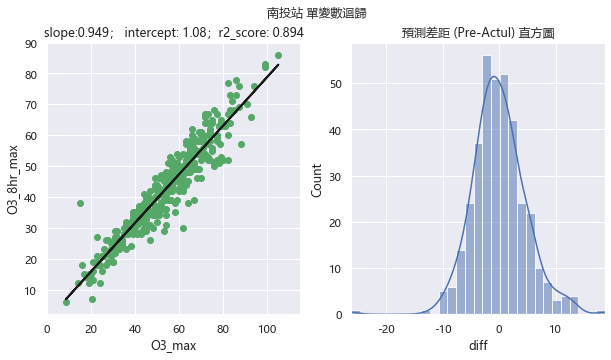

In [24]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

for s in df_result["SiteName"].unique()[0:1]:
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic["SiteName"].isin([s])) & (df_pic["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train]['O3_max'].values.reshape(-1,1) 
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic[mask_test_self]['O3'].values.reshape(-1,1) 
    y_test_self = df_pic[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic[mask_test_next]['O3'].values.reshape(-1,1) 
    y_test_next = df_pic[mask_test_next]['O3_8hr'].values.reshape(-1,1)
    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_simple_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_simple_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # normalized back
    X_train = min_max_scaler_simple_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    
    # Plot outputs
    fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
    fig.suptitle(f'{s}站 單變數迴歸\n\n\n')
    
    axes[0].scatter(X_train, y_train,  color='g')
    axes[0].plot(X_train, y_train_pred, color='k', linewidth=2)
    axes[0].set_xlim(0, X_train.max()+10)
    axes[0].set_xlabel('O3_max')
    axes[0].set_ylabel('O3_8hr_max')
    axes[0].set_title(f"slope:{round(reg.coef_[0][0],3)}； intercept: {round(reg.intercept_[0],3)}；r2_score: {round(r2_score(y_train, y_train_pred),3)}")
    
    # diff hist()
    single_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    single_reg_diff.loc[:, "diff"] = single_reg_diff.loc[: ,"Predicted"] - single_reg_diff.loc[: ,"Actual"]
    sns.histplot(data=single_reg_diff, x="diff", kde=True, ax=axes[1])
    axes[1].set_xlim(single_reg_diff.loc[:, "diff"].min(), single_reg_diff.loc[:, "diff"].max())
    axes[1].set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

### 當年度驗證 self

In [25]:
# normalized
X_test_self = min_max_scaler_simple_X.transform(X_test_self)

# 以模型預測每小時資料
y_test_self_pred = reg.predict(X_test_self)

# normalized back
X_test_self = min_max_scaler_simple_X.inverse_transform(X_test_self)
y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_self = df_pic[mask_test_self].reset_index(drop=True).copy(deep=True)
df_self.loc[:,"y_pred"] = y_test_self_pred
df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_self = df_self.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")


# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")


# 計算 TP  預警時間、提早時數
mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 352
>> FP: 2
>> FN: 6
>> TP: 4

>> 預警成功率: 0.4
>> 假警報率: 0.333

>> 預警成功 發布時間點 統計:
時間點   次數
13    3
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    3
4.0    1
dtype: int64


### 下年度驗證 next

In [26]:
# normalized
X_test_next = min_max_scaler_simple_X.transform(X_test_next)

# 以模型預測每小時資料
y_test_next_pred = reg.predict(X_test_next)

# normalized back
X_test_next = min_max_scaler_simple_X.inverse_transform(X_test_next)
y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)

# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_next = df_pic[mask_test_next].reset_index(drop=True).copy(deep=True)
df_next.loc[:,"y_pred"] = y_test_next_pred
df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_next = df_next.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 342
>> FP: 1
>> FN: 10
>> TP: 12

>> 預警成功率: 0.545
>> 假警報率: 0.077

>> 預警成功 發布時間點 統計:
時間點   次數
13    5
12    3
14    3
15    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
3.0    5
4.0    4
2.0    2
5.0    1
dtype: int64


## 複迴歸測試

### 參數設定

In [52]:
object_lst_new

['AMB_TEMP_max']

In [483]:
# # 變數設定
# X_col_model = [
#  'O3_max',
#  'CO_max',
#  'NOx_max',
# #  'NO_max',
#  'NO2_max',
# #  'SO2_max',
#  'AMB_TEMP_max',
# #  'CH4_max',
#  'NMHC_max',
# #  'THC_max'
# ]

# X_col_test = [
#  'O3',
#  'CO_max',
#  'NOx_max',
# #  'NO_max',
#  'NO2_max',
# #  'SO2_max',
#  'AMB_TEMP_max',
# #  'CH4_max',
#  'NMHC_max',
# #  'THC_max'
# ]
# df_pic_for_model = df_pic_1.copy(deep=True)


In [559]:
# # 變數設定 (for df_pic_6)
# X_col_model = ['O3_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
# X_col_test = ['O3','O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
# df_pic_for_model = df_pic_6.copy(deep=True)

In [53]:
# # 變數設定 (for df_pic_7)
# X_col_model = ['O3_max', 'O3_0to5mean','WIND_SPEED_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean']
# X_col_test = ['O3', 'O3_0to5mean','WIND_SPEED_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean']
# df_pic_for_model = df_pic_7.copy(deep=True)

# # 變數設定 (for df_pic_8)
# X_col_model = ['O3_max', 'O3_0to5mean','WIND_SPEED_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean','AMB_TEMP_max']
# X_col_test = ['O3', 'O3_0to5mean','WIND_SPEED_0to5mean', 'CO_0to5mean', 'NMHC_0to5mean', 'AMB_TEMP_max']
# df_pic_for_model = df_pic_8.copy(deep=True)

# 變數設定 (for df_pic_9)
X_col_model = ['O3_max','AMB_TEMP_max']
X_col_test = ['O3', 'AMB_TEMP_max']
df_pic_for_model = df_pic_9.copy(deep=True)

In [54]:
# 刪除遺漏值
df_result.dropna(subset=X_col_model+["O3_8hr_max"], how='any', inplace=True)

print(f">> 刪除row數: {len(df_pic_for_model) - len(df_pic_for_model.dropna(subset=X_col_test+['O3_8hr_max'], how='any'))}")
df_pic_for_model.dropna(subset=X_col_test+["O3_8hr_max"], how='any', inplace=True)

df_pic_for_model.columns

>> 刪除row數: 0


Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour', 'O3_max', 'AMB_TEMP_max'],
      dtype='object')

>> X:['O3_max', 'AMB_TEMP_max']
>> slope:[[0.93756184 0.03605643]]
>> pvalue:[0.0, 0.059]
>> intercept: -0.886
>> r2_score: 0.895

>> Mean Absolute Error: 3.1517922732285863
>> Root Mean Squared Error: 4.184197585604066


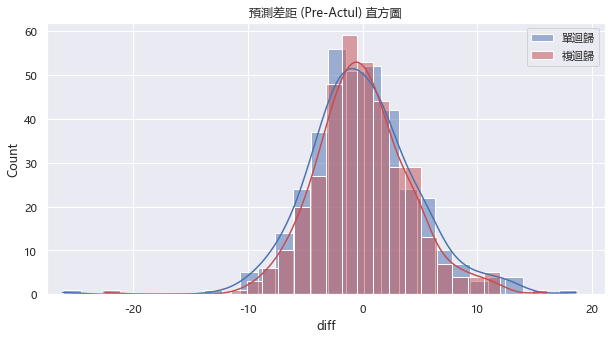

In [55]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

for s in df_result["SiteName"].unique()[0:1]:
    # mask
    mask_train = (df_result["SiteName"].isin([s])) & (df_result["date"].apply(lambda d: d.year)==2018)
    mask_test_self = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2018)
    mask_test_next = (df_pic_for_model["SiteName"].isin([s])) & (df_pic_for_model["date"].apply(lambda d: d.year)==2019)
    
    #split dataset
    #     for model
    X_train = df_result[mask_train][X_col_model].values
    y_train = df_result[mask_train]['O3_8hr_max'].values.reshape(-1,1) 

    #  for test_self
    X_test_self = df_pic_for_model[mask_test_self][X_col_test].values
    y_test_self = df_pic_for_model[mask_test_self]['O3_8hr'].values.reshape(-1,1)
    
    # for test_next
    X_test_next = df_pic_for_model[mask_test_next][X_col_test].values
    y_test_next = df_pic_for_model[mask_test_next]['O3_8hr'].values.reshape(-1,1)

    
    # normalized
    feature_range = (0, 100)
    min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
    min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
    X_train = min_max_scaler_multi_X.fit_transform(X_train)
    y_train = min_max_scaler_y.fit_transform(y_train)
    
    # model
    reg = LinearRegression(fit_intercept=True)  
    reg.fit(X_train, y_train) # 訓練模型
    y_train_pred = reg.predict(X_train) # 預測
    
    # model summery by statsmodels.api as sm
    X_train_2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_train_2)
    est2 = est.fit()
    
    # normalized back
    X_train = min_max_scaler_multi_X.inverse_transform(X_train)
    y_train = min_max_scaler_y.inverse_transform(y_train)
    y_train_pred = min_max_scaler_y.inverse_transform(y_train_pred)
    

    
    # Print outputs
    print(f">> X:{X_col_model}")
    print(f">> slope:{reg.coef_}")
    print(f">> pvalue:{est2.pvalues.round(3)[1:].tolist()}")
    print(f">> intercept: {round(reg.intercept_[0],3)}")
    print(f">> r2_score: {round(r2_score(y_train, y_train_pred),3)}\n")
#     print(est2.summary())
    
    
    # 單變數迴歸 diff: single_reg_diff
    
    # 複迴歸 diff: mutil_reg_diff
    mutil_reg_diff = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()})
    mutil_reg_diff.loc[:, "diff"] = mutil_reg_diff.loc[: ,"Predicted"] - mutil_reg_diff.loc[: ,"Actual"]

    # 疊圖
    fig, ax = plt.subplots(figsize=(10,5))
    for idx, d in enumerate([single_reg_diff, mutil_reg_diff]):
        if idx==1:
            color = 'r'
            label = "複迴歸"
        else:
            color = 'b'
            label = "單迴歸"
            
        sns.histplot(data=d, x="diff" ,ax=ax, kde=True, color=color, label=label)
    ax.set_xlim(mutil_reg_diff.loc[:, "diff"].min()-5, mutil_reg_diff.loc[:, "diff"].max()+5)
    ax.legend()
    ax.set_title(f"預測差距 (Pre-Actul) 直方圖")
    
    print('>> Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))  
#     print('>> Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))  
    print('>> Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

In [198]:


# >> X:['O3_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
# >> slope:[[ 0.95468569  0.0535099   0.01237221 -0.05291225  0.00974897]]
# >> pvalue:[0.0, 0.003, 0.647, 0.105, 0.737]
# >> intercept: 0.512
# >> r2_score: 0.899

# >> X:['O3_max', 'CO_max', 'NOx_max', 'NO2_max', 'AMB_TEMP_max', 'NMHC_max']
# >> slope:[[ 0.92796874  0.00384959 -0.17795997  0.08061835  0.00295194  0.00416461]]
# >> pvalue:[0.0, 0.921, 0.001, 0.037, 0.906, 0.873]
# >> intercept: 3.125
# >> r2_score: 0.9

# 加入 溫度max
# >> X:['O3_max', 'AMB_TEMP_max', 'O3_1to6mean', 'CO_1to6mean', 'NO2_1to6mean', 'NMHC_1to6mean']
# >> slope:[[ 0.91490441  0.08154962  0.08718578  0.03304816 -0.03892152  0.02463813]]
# >> pvalue:[0.0, 0.002, 0.0, 0.23, 0.231, 0.396]
# >> intercept: -5.667
# >> r2_score: 0.902

### 當年度驗證 self 

In [56]:
# normalized
X_test_self = min_max_scaler_multi_X.transform(X_test_self)

# 以模型預測每小時資料
y_test_self_pred = reg.predict(X_test_self)

# normalized back
X_test_self = min_max_scaler_multi_X.inverse_transform(X_test_self)
y_test_self_pred = min_max_scaler_y.inverse_transform(y_test_self_pred)


# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_self = df_pic_for_model[mask_test_self].reset_index(drop=True).copy(deep=True)
df_self.loc[:,"y_pred"] = y_test_self_pred
df_self.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_self_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_self = df_self.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_self["is_exceed_date"].values, df_self[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()
print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_self["is_exceed_date"].isin([True])) &(df_self[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_self[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_self[mask_TP]['real_exceed_hour']) -(df_self[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 304
>> FP: 50
>> FN: 0
>> TP: 10

>> 預警成功率: 1.0
>> 假警報率: 0.833

>> 預警成功 發布時間點 統計:
時間點   次數
10    5
11    4
12    1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
6.0    4
5.0    4
7.0    2
dtype: int64


### 下年度驗證 next

In [57]:
# normalized
X_test_next = min_max_scaler_multi_X.transform(X_test_next)

# 以模型預測每小時資料
y_test_next_pred = reg.predict(X_test_next)

# normalized back
X_test_next = min_max_scaler_multi_X.inverse_transform(X_test_next)
y_test_next_pred = min_max_scaler_y.inverse_transform(y_test_next_pred)


# 定義預測超標門檻值
exceed_value_pred = 71 # 預測超標門檻值

# 取用小時值資料
df_next = df_pic_for_model[mask_test_next].reset_index(drop=True).copy(deep=True)
df_next.loc[:,"y_pred"] = y_test_next_pred
df_next.loc[:,f"is_y_pred_ge_{exceed_value_pred}"] = (y_test_next_pred>=exceed_value_pred)

# 挑選出每天最早預測超標的小時資料、若皆無預測超標，則會為0時的資料
df_next = df_next.sort_values(
            by=["date", f"is_y_pred_ge_{exceed_value_pred}", "DataCreationDate"],
                ascending=[1,0,1]).drop_duplicates(subset=["date"], keep="first")

# 驗證對錯>>混淆矩陣
# metrics.confusion_matrix(y_true, y_pred)
# (tn, fp, fn, tp)
cm = metrics.confusion_matrix(df_next["is_exceed_date"].values, df_next[f"is_y_pred_ge_{exceed_value_pred}"].values).ravel()

print(f">>預測目標門檻值: {exceed_value_pred}\n")
print(f">> TN: {cm[0]}\n>> FP: {cm[1]}\n>> FN: {cm[2]}\n>> TP: {cm[3]}\n")
print(f">> 預警成功率: {round((cm[3]/(cm[2]+cm[3])),3)}\n>> 假警報率: {round((cm[1]/(cm[1]+cm[3])),3)}\n")

# 計算 TP  預警時間、提早時數
mask_TP = (df_next["is_exceed_date"].isin([True])) &(df_next[f"is_y_pred_ge_{exceed_value_pred}"].isin([True]))

print(f">> 預警成功 發布時間點 統計:\n時間點   次數\n{df_next[mask_TP]['DataCreationDate'].dt.hour.value_counts()}")
print(f">> 預警成功 提早時數 統計:\n提早時數   次數\n{((df_next[mask_TP]['real_exceed_hour']) -(df_next[mask_TP]['DataCreationDate'].dt.hour)).value_counts()}")

>>預測目標門檻值: 71

>> TN: 292
>> FP: 51
>> FN: 0
>> TP: 22

>> 預警成功率: 1.0
>> 假警報率: 0.699

>> 預警成功 發布時間點 統計:
時間點   次數
12    10
11     6
10     4
13     1
14     1
Name: DataCreationDate, dtype: int64
>> 預警成功 提早時數 統計:
提早時數   次數
5.0    9
6.0    9
4.0    2
3.0    1
7.0    1
dtype: int64


In [441]:
# (最大溫度 與 O3平均值 互相干擾(內生性問題))

### 檢查

In [187]:
# 檢查 超標次數 會因為變數值遺漏而缺漏 EX 4
mask = (df_pic_4["SiteName"].isin(["南投"])) & (df_pic_4["DataCreationDate"].dt.year==2019) & (df_pic_4["is_exceed_date"].isin([True]))
df_pic_4[mask].drop_duplicates(subset=["date"]).sort_values(by=["date"])[["date","O3_gradian_diff_7to12"]]

,date,O3_gradian_diff_7to12
120713,2019-07-17,NaN
115511,2019-08-22,58.0
115730,2019-08-23,81.0
116792,2019-08-28,57.0
104939,2019-09-02,NaN
106840,2019-09-11,55.0
107044,2019-09-12,66.0
109180,2019-09-22,52.0
109394,2019-09-23,64.0
109608,2019-09-24,70.0


In [197]:
# 檢查 細看
date_lst = [datetime.date(2019,7,17), datetime.date(2019,9,2)]
mask = (df_pic_4["SiteName"].isin(["南投"])) & (df_pic_4["date"].isin(date_lst)) 
df_pic_4[mask].sort_values(by=["DataCreationDate"])[["DataCreationDate","O3"]] # 原始資料缺值

,DataCreationDate,O3
120713,2019-07-17 17:00:00,82.0
120729,2019-07-17 19:00:00,72.0
120740,2019-07-17 20:00:00,57.0
120748,2019-07-17 21:00:00,43.0
120758,2019-07-17 22:00:00,38.0
120765,2019-07-17 23:00:00,35.0
104939,2019-09-02 00:00:00,11.0
104947,2019-09-02 01:00:00,7.0
104953,2019-09-02 02:00:00,8.0
104961,2019-09-02 03:00:00,6.0


- 以 2019.7.17 南投測站為例， [資料來源](https://data.epa.gov.tw/dataset/aqx_p_488/resource/7b28386e-6624-4b26-a007-a977cbb14ddf)


![Imgur](https://imgur.com/zoBWcqw.png)

## 以全小時值進行 複回歸 測試

In [286]:
df_pic.columns

Index(['SiteName', 'DataCreationDate', 'O3_8hr', 'CO_8hr', 'PM2.5_AVG',
       'PM10_AVG', 'SO2_AVG', 'AMB_TEMP', 'CH4', 'CO', 'CO2', 'NMHC', 'NO',
       'NO2', 'NOx', 'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND',
       'RAIN_INT', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED',
       'WS_HR', 'date', 'AreaName', 'SiteType', 'O3_8hr_max', 'is_exceed_date',
       'real_exceed_hour'],
      dtype='object')

In [332]:
X_cols = ["CO", 'NMHC', 'NO', 'NO2', 'NOx', 'AMB_TEMP']
y_cols = "O3"

X = df_pic[X_cols].copy(deep=True)
y = df_pic[y_cols].copy(deep=True)

# normalized
feature_range = (0, 100)
min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
X_s_array = min_max_scaler_multi_X.fit_transform(X)
y_s_array = min_max_scaler_y.fit_transform(y.values.reshape(-1,1))

X.loc[:, X_cols] = pd.DataFrame(X_s_array, columns = X_cols)
y = pd.DataFrame(y_s_array, columns = [y_cols])

# model summery by statsmodels.api as sm
X_2 = sm.add_constant(X)
est = sm.OLS(y, X_2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                 1.108e+04
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:02:45   Log-Likelihood:            -9.5197e+05
No. Observations:              243717   AIC:                         1.904e+06
Df Residuals:                  243710   BIC:                         1.904e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6744      0.135      5.009      0.0

In [333]:
X_cols = ["CO", 'NMHC', 'NO', 'NO2', 'NOx', 'AMB_TEMP']
y_cols = "O3_8hr"

X = df_pic[X_cols].copy(deep=True)
y = df_pic[y_cols].copy(deep=True)

# normalized
feature_range = (0, 100)
min_max_scaler_multi_X = preprocessing.MinMaxScaler(feature_range=feature_range)
min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=feature_range)
X_s_array = min_max_scaler_multi_X.fit_transform(X)
y_s_array = min_max_scaler_y.fit_transform(y.values.reshape(-1,1))

X.loc[:, X_cols] = pd.DataFrame(X_s_array, columns = X_cols)
y = pd.DataFrame(y_s_array, columns = [y_cols])


# model summery by statsmodels.api as sm
X_2 = sm.add_constant(X)
est = sm.OLS(y, X_2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 O3_8hr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     9031.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:02:51   Log-Likelihood:            -9.7751e+05
No. Observations:              243717   AIC:                         1.955e+06
Df Residuals:                  243710   BIC:                         1.955e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3523      0.150     75.927      0.0

# 分鐘值 與 小時值

[系統](https://iot.epa.gov.tw/iot/downloadCenter) 最久可回溯到一年前

## 挑選範例超標站日

In [171]:
# 篩選測站 & 篩選年分
site_lst = ["南投"]
year_min_max = [2020]
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year==year_min_max[0])
df_pic_for_min = df[pic_mask].reset_index(drop=True)
df_pic_for_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9673 entries, 0 to 9672
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             9673 non-null   int64         
 1   SiteName          9673 non-null   object        
 2   County            9673 non-null   object        
 3   AQI               9669 non-null   float64       
 4   Pollutant         5034 non-null   object        
 5   Status            9671 non-null   object        
 6   SO2               9271 non-null   float64       
 7   CO                9567 non-null   float64       
 8   O3                9552 non-null   float64       
 9   O3_8hr            9639 non-null   float64       
 10  PM10              9494 non-null   float64       
 11  PM2.5             9506 non-null   float64       
 12  NO2               9553 non-null   float64       
 13  NOx               9554 non-null   float64       
 14  NO                9551 n

In [173]:
max_date = df_pic_for_min[df_pic_for_min["O3_8hr"]>=71]["date"].unique().max()
max_date

datetime.date(2020, 11, 26)

<AxesSubplot:xlabel='DataCreationDate'>

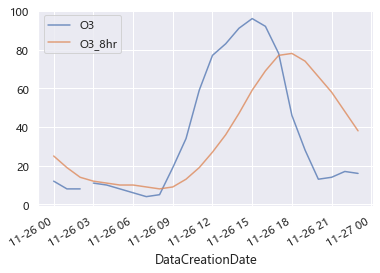

In [174]:
date_lst = [max_date]
mask =  (df_pic_for_min["date"].isin(date_lst)) 
df_hour_for_plot = df_pic_for_min[mask].sort_values(by=["DataCreationDate"])[["DataCreationDate","O3","O3_8hr"]].set_index('DataCreationDate')
df_hour_for_plot.plot(alpha=0.75)

## 讀取分鐘值資料

In [175]:
path = r"G:\我的雲端硬碟\work\2021\3.環保署_環境即時通專案\110年\3.空品分鐘值資料\南投_20201126\rawdata_2021-07-09_10-23-39_0.csv"
df_min = read_data_dir_fPathExt(path)

# 格式轉換
df_min.loc[:, "TIME"] = pd.to_datetime(df_min.loc[:, "TIME"])
df_min.rename(columns={"VALUE":"O3_min","TIME":"DataCreationDate"}, inplace=True)
df_min.loc[:,"O3_min"] = pd.to_numeric(df_min.loc[:,"O3_min"])

df_min.info()

  >> 讀取:: G:\我的雲端硬碟\work\2021\3.環保署_環境即時通專案\110年\3.空品分鐘值資料\南投_20201126\rawdata_2021-07-09_10-23-39_0.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DEVICE_ID         1441 non-null   int64         
 1   DEVICE_NAME       1441 non-null   object        
 2   LON               1441 non-null   float64       
 3   LAT               1441 non-null   float64       
 4   DataCreationDate  1441 non-null   datetime64[ns]
 5   area              0 non-null      float64       
 6   areaType          0 non-null      float64       
 7   town              0 non-null      float64       
 8   SENSOR(UNIT)      1441 non-null   object        
 9   O3_min            1441 non-null   float64       
 10  ValueRaw          1441 non-null   float64       
 11  Status            1441 non-null   int64         
 12  ValueSD           1441 non-

<AxesSubplot:xlabel='DataCreationDate'>

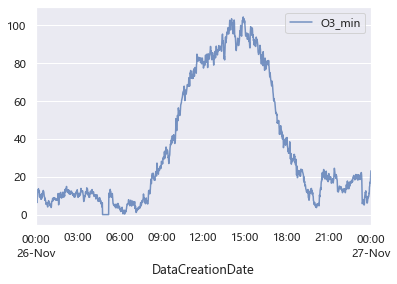

In [176]:
df_min_for_plot = df_min.sort_values(by=["DataCreationDate"])[["DataCreationDate","O3_min"]].set_index('DataCreationDate')
df_min_for_plot.plot(alpha=0.75)

## 疊圖 

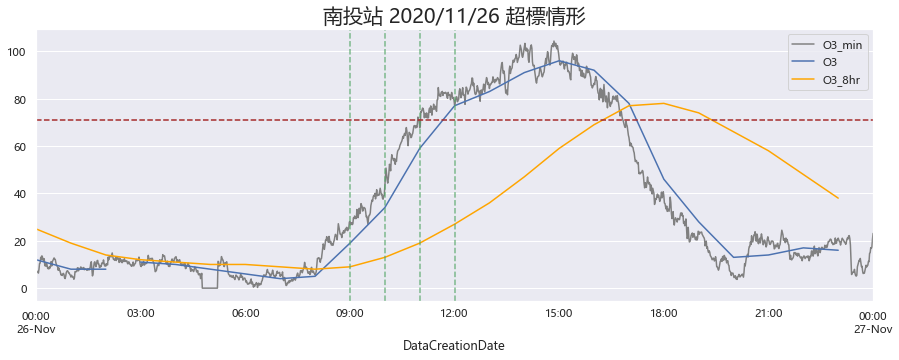

In [189]:
# 分鐘值 df_hour_for_plot   
# 小時值 df_min_for_plot

# 疊圖
fig, ax = plt.subplots(figsize=(15,5))
df_min_for_plot.plot(ax=ax, color='gray')
df_hour_for_plot.plot(ax=ax, color=['b','orange'])
ax.set_title(f"南投站 2020/11/26 超標情形", fontsize=20)
for hour in range(9,12+1):
    ax.axvline(datetime.datetime(2020,11,26,hour,0,0), 0,1, color='g',alpha=0.75).set_linestyle("--") # 小時輔助線
ax.axhline(71, 0,1, color='brown').set_linestyle("--") # 閾值輔助線 

> 假設閾值 71， 小時值: 12:00達到、分鐘值 11:00達到

O3 滾動式5分鐘平均值(挑2個)，7點之後第1次O3分鐘值超過71，的當分鐘(平均值)與前60分鐘(平均值)的**斜率**
- 2018~2020 超標日，的**斜率範圍/統計**
- 2018~2020 非超標日，的**斜率範圍/統計**

## 計算測站 O3小時值缺值情況 

In [4]:
# 篩選測站 & 篩選年分
site_lst = ["新店", "板橋", "古亭", "南投","竹山","埔里", "屏東","潮州","小港"]
year_pic = 2019
pic_mask = (df["SiteName"].isin(site_lst)) & (df["DataCreationDate"].dt.year==year_pic)
df_pic_for_check_nan = df[pic_mask].reset_index(drop=True)
df_pic_for_check_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78813 entries, 0 to 78812
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             78813 non-null  int64         
 1   SiteName          78813 non-null  object        
 2   County            78813 non-null  object        
 3   AQI               76776 non-null  float64       
 4   Pollutant         41123 non-null  object        
 5   Status            78813 non-null  object        
 6   SO2               76159 non-null  float64       
 7   CO                76594 non-null  float64       
 8   O3                76452 non-null  float64       
 9   O3_8hr            77576 non-null  float64       
 10  PM10              75324 non-null  float64       
 11  PM2.5             73922 non-null  float64       
 12  NO2               75477 non-null  float64       
 13  NOx               75477 non-null  float64       
 14  NO                7547

In [122]:
df_pic_for_check_nan.loc[:, "is_O3_nan"] = df_pic_for_check_nan.loc[:, "O3"].isnull()
df_pic_for_check_nan.loc[:, "hour"] = df_pic_for_check_nan.loc[:, "DataCreationDate"].dt.hour 

mask_nan = df_pic_for_check_nan.loc[:, "is_O3_nan"].isin([True])
pd.pivot_table(df_pic_for_check_nan, index = ["SiteName", "hour"], values = ["is_O3_nan"], aggfunc = "sum").reset_index()


,SiteName,hour,is_O3_nan
0,南投,0,18
1,南投,1,17
2,南投,2,19
3,南投,3,17
4,南投,4,20
...,...,...,...
211,竹山,19,9
212,竹山,20,5
213,竹山,21,4
214,竹山,22,6


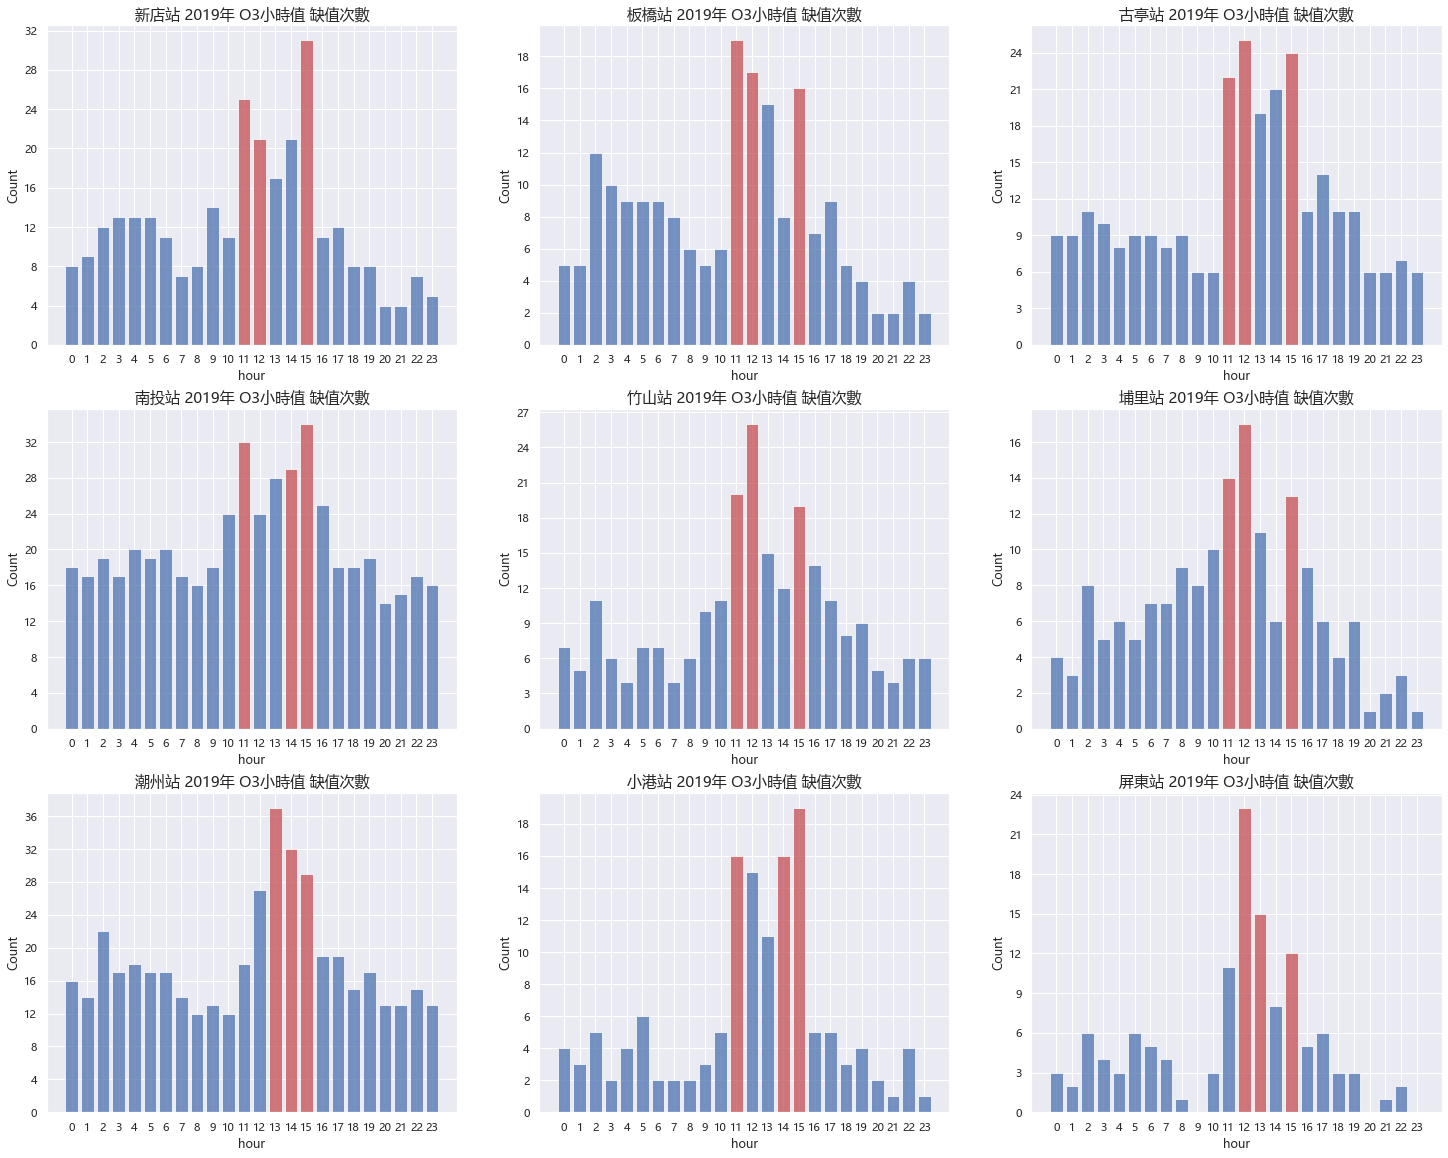

In [151]:
df_pic_for_check_nan.loc[:, "is_O3_nan"] = df_pic_for_check_nan.loc[:, "O3"].isnull()
df_pic_for_check_nan.loc[:, "hour"] = df_pic_for_check_nan.loc[:, "DataCreationDate"].dt.hour 
# pivot
df_pivot_for_plot = pd.pivot_table(df_pic_for_check_nan, index = ["SiteName", "hour"], values = ["is_O3_nan"], aggfunc = "sum").reset_index()

#組圖
ncol = 3 # 一排幾張圖
nrows = math.ceil(len(site_lst)/ncol)
top = 3 # 特別標記

fig, ax = plt.subplots(nrows=nrows, ncols=ncol, figsize=(25,20))
# for idx, site in enumerate(site_lst):
for idx, site in enumerate(site_lst):
    row = math.floor(idx/ncol)
    col = idx % ncol
    
    site_mask = df_pivot_for_plot.loc[:, "SiteName"].isin([site])
    top_hour = df_pivot_for_plot[site_mask].set_index("hour").sort_values(by=["is_O3_nan"], ascending=0).head(top).index.values
    color = ['b' if h not in top_hour else 'r' for h in range(0,23+1)]
    data = df_pivot_for_plot[site_mask].set_index("hour")
    
    ax[row,col].bar(x=data.index, height=data.is_O3_nan ,alpha=0.75 ,color=color)
    ax[row,col].set_xticks(data.index)
    ax[row,col].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[row,col].set_title(f"{site}站 {year_pic}年 O3小時值 缺值次數", fontsize=15)
    ax[row,col].set_xlabel("hour")
    ax[row,col].set_ylabel("Count")

In [153]:
formtoXlsx(df_pivot_for_plot, "測站各小時缺值紀錄")

 >>> 建立今天的工作區: 0708
 ==輸出備份xlsx== ::: 測站各小時缺值紀錄_20210708_16.16.58.xlsx
